## Purpose

The purpose of this notebook is to process the network models from the [CSIRO Low Voltage Feeder Taxonomy](http://linked.data.gov.au/dataset/energy/f325fb3c-2dcd-410c-97a8-e55dc68b8064) project.

These network models are specified as Open DSS input files. We need them in Pandapower format in order to work with the MAPDN simulation setup.


For this project we will convert the network models of the following networks:
- J
- Q
- L

These networks were selected as they were highlighted in the Low Voltage Feeder Taxonomy report as networks with significant voltage challenges. As such, they are good test cases for reinforcement learning agents. 
## Approach

The approach for converting networks will be semi-automatic. The aim will be to write scripts which can convert the line codes, loads and lines into dictionaries than can be loaded into pandapower directly. But, there are some elements of the OpenDSS models that will not translate as easily and will require some manual intervention. 

Notably, we will be removing transformers from the models. 

This is done for several reasons. Firstly, the reinforcement learning agents have no control over transformer tap settings (as they have in previous studies), and the metric used to measure agent performance is bus voltages, not reverse power flows across a transformer. Secondly, there are significant data quality issues with the transformer configurations produced by the LVFT as a result of the poor quality input data they received from DNSPs. "...and inconsistent or missing switch labelling, impedance representations and transformer configurations were among the most problematic and prevalent features of the majority of network models provided". Finally, the process for converting transformer representations from OpenDSS to Pandapower is not evident. Consequently it was deemed that attempting to convert network elements that were not required for the model, likely misconfigured, and difficult to translate across modelling paradigms would be a net negative for the modelling accuracy of the project.

One of the major challenges here will be creating a correspondence between bus numbers given in the OpenDSS files and those in Pandapower. In the OpenDSS files the buses are given arbitrary numbers whilst in Pandapower buses are counted in the order they are created in starting from 0.




### Three phase powerflow

One of the contributions of this project is to use a 3 phase unbalanced power flow as the basis for the environment agents interact with. For the sake of simplicity we assume that loads are single phase and their PV systems are attached to the same phase.

Where the OpenDSS files show that a load is attached to multiple phases, one of the phases is randomly selected. 

In [1]:
from pathlib import Path
from typing import List, Union
import re
import operator
import random
import json
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
INPUT_DATA_PATH = Path("./input_network_models")
OUTPUT_DATA_PATH = Path("./output_network_models")
NETWORKS_INFO = {
    "J": {
        "slack_bus_index": 21,
        "ext_grid_pu": 1.04,
    },
    "Q": {
        "slack_bus_index": 116,
        "ext_grid_pu": 1.0,
    },
    "L": {
        "slack_bus_index": 2,
        "ext_grid_pu": 1.0,
    },
}


In [3]:
# A bunch of useful maps and constants for processing the files
x_r_map = {
    "r1": "r_ohm_per_km",
    "r0": "r0_ohm_per_km",
    "x1": "x_ohm_per_km",
    "x0": "x0_ohm_per_km",
    "c0": "c0_nf_per_km",
    "c1": "c_nf_per_km",
}

lines_treatment_map = {
    "length": {
        "fn": lambda x: float(x),
        "name": "length_km",
    },
    "bus1": {
        "fn": lambda x: x.split(".")[0],
        "name": "from_bus",
    },
    "bus2": {
        "fn": lambda x: x.split(".")[0],
        "name": "to_bus",
    },
    "enabled": {
        "fn": lambda x: True if "y" in x or "true" in x else False,
        "name": "in_service",
    },
    "linecode": {"fn": lambda x: x, "name": "std_type"},
}


phase_map = {"1": "a", "2": "b", "3": "c"}

ops = {"+": operator.add, "-": operator.sub, "*": operator.mul, "/": operator.truediv}

# It's not pretty, it's hyper-specific
# But it works
line_split_regex = r"[\w\.]*=*\(*[\w\s\.*]+\)*\s"


In [4]:
# The actual functions for processing the networks


def split_row(row: str) -> List[re.Match]:
    return re.finditer(line_split_regex, row, re.MULTILINE)


def process_load_row(line: str, bus_index_map: dict):
    load_info = {}
    for match in split_row(line):
        match = str(match.group()).strip().lower()
        if "line." in match:
            load_info["name"] = match.split(".")[1]
        elif "bus1" in match:
            bus_info = match.split("=")[1].split(".")
            load_info["bus"] = bus_index_map[bus_info[0]]
            phases = [v for v in bus_info[1:]]
            # If the bus has multiple phases randomly select one to assign it to
            load_info["phase"] = phase_map[random.choice(phases)]
    return load_info


def process_linecode_row(line: str):
    line_data = {
        "name": None,
        # We assume 0 capacitance in line with other works
        "c_nf_per_km": 0,
        "c0_nf_per_km": 0,
        "r_ohm_per_km": None,
        "r0_ohm_per_km": None,
        "x_ohm_per_km": None,
        "x0_ohm_per_km": None,
        # We don't care about maximum thermal current for the line, we aren't looking at faults -> set it unreasonably high
        "max_i_ka": 5,
        "std_type": "line",
    }

    for match in split_row(line):
        match = str(match.group()).strip().lower()
        if "linecode" in match:
            line_data["name"] = match.split(".")[1]
        if match.startswith(("r1", "r0", "x0", "x1", "c0", "c1")):
            key, value = process_x_r_property(match)
            pp_property_name = x_r_map[key]
            line_data[pp_property_name] = value
    return line_data


def get_file_path_from_list(filename: str, file_list: List[Path]) -> Union[Path, None]:
    return next(filter(lambda x: filename in str(x).lower(), file_list), None)


def process_x_r_property(property):
    # This won't work for nested brackets, lord help us if there are any
    key, value = property.split("=")
    if "(" in value:
        # Split on as many spaces as there are between operands
        num1, num2, op = re.split(r"\s+", value.replace("(", "").replace(")", ""))
        value = ops[op](float(num1), float(num2))
    else:
        value = float(value)
    return key, value


def process_line_row(line: str):
    row_data = {}
    for match in split_row(line):
        match = str(match.group()).strip().lower()
        if "line." in match:
            row_data["name"] = match.split(".")[1]
        if "=" in match:
            key, value = match.split("=")
            treatment = lines_treatment_map.get(key, None)
            if not treatment:
                continue
            row_data[treatment["name"]] = treatment["fn"](value)
    return row_data


# Note to future readers: this solution is massively overfit
# to the structure of the files I am dealing with.
# This is in no way an effort to make a general OpenDSS -> pandapower converter
def process_linecodes(linecode_path: Path):
    linecodes = []
    with open(linecode_path, "r") as infile:
        for row in infile:
            linecodes.append(process_linecode_row(row))
    return linecodes


def process_lines(lines_path):
    buses = []
    lines = []
    bus_index_map = {}
    bus_count = 0
    with open(lines_path, "r") as infile:
        for row in infile:
            processed_line = process_line_row(row)
            from_bus = processed_line["from_bus"]
            to_bus = processed_line["to_bus"]
            existing_buses = bus_index_map.keys()
            if from_bus not in existing_buses:
                buses.append({"name": from_bus, "index": bus_count})
                bus_index_map[from_bus] = bus_count
                bus_count += 1
            if to_bus not in existing_buses:
                buses.append({"name": to_bus, "index": bus_count})
                bus_index_map[to_bus] = bus_count
                bus_count += 1
            lines.append(
                {
                    **processed_line,
                    "from_bus": bus_index_map[from_bus],
                    "to_bus": bus_index_map[to_bus],
                }
            )

    return buses, lines, bus_index_map


def process_loads(loads_path, bus_index_map: dict):
    loads = []
    with open(loads_path, "r") as infile:
        for row in infile:
            loads.append(process_load_row(row, bus_index_map))
    return loads


def save_json_data(data: dict, file_path: str):
    with open(file_path, "w") as outfile:
        outfile.write(json.dumps(data))


def load_json(file_path: Path) -> dict:
    with open(file_path, "r") as infile:
        return json.loads(infile.read())


In [7]:
random.seed(42)


def process_network(network_name: str):
    input_network_path = INPUT_DATA_PATH / network_name
    output_network_path = OUTPUT_DATA_PATH / network_name

    file_list = list(input_network_path.iterdir())

    linecodes_path = get_file_path_from_list("linecode", file_list)
    lines_path = get_file_path_from_list("lines", file_list)
    loads_path = get_file_path_from_list("loads", file_list)

    if any(x is None for x in [linecodes_path, lines_path, loads_path]):
        raise ValueError(f"Can't process network without linecodes, lines and loads")
    linecodes = process_linecodes(linecodes_path)
    buses, lines, bus_index_map = process_lines(lines_path)
    loads = process_loads(loads_path, bus_index_map)

    output_network_path.mkdir(exist_ok=True, parents=True)
    save_json_data(linecodes, output_network_path / "linecodes.json")
    save_json_data(buses, output_network_path / "buses.json")
    save_json_data(lines, output_network_path / "lines.json")
    save_json_data(loads, output_network_path / "loads.json")

    pd.DataFrame(bus_index_map, index=[0]).to_csv(
        output_network_path / "bus_index_map.csv"
    )


def build_network(
    slack_bus_index,
    ext_grid_pu,
    path,
    base_bus_kv=0.416,
    default_load_mw=0,
    default_load_mvar=0,
    default_sgen_mw=0,
    default_sgen_mvar=0,
    sgen_proportion=0.5,
    random_state=42,
):
    random.seed(random_state)
    bus_path = path / "buses.json"
    linecodes_path = path / "linecodes.json"
    lines_path = path / "lines.json"
    loads_path = path / "loads.json"

    buses = load_json(bus_path)
    loads = load_json(loads_path)
    linecodes = load_json(linecodes_path)
    lines = load_json(lines_path)

    net = pp.create_empty_network()

    for linecode in linecodes:
        pp.create_std_type(net, linecode, linecode["name"], element="line")

    for bus in buses:
        pp.create_bus(net, vn_kv=base_bus_kv, **bus)

    for line in lines:
        pp.create_line(net, **line)

    for load in loads:
        phase = load["phase"]
        bus = load["bus"]
        load_data = {
            "net": net,
            "bus": bus,
            "name": phase,
            "p_a_mw": 0,
            "p_b_mw": 0,
            "p_c_mw": 0,
            "q_a_mvar": 0,
            "q_b_mvar": 0,
            "q_c_mvar": 0,
            # Override the active and reactive power values set above for the relevant phase
            f"p_{phase}_mw": default_load_mw,
            f"q_{phase}_mvar": default_load_mvar,
        }
        load = pp.create_asymmetric_load(
            **load_data,
        )

        if random.random() <= sgen_proportion:
            sgen_data = {
                "net": net,
                "bus": bus,
                "name": phase,
                "p_a_mw": 0,
                "p_b_mw": 0,
                "q_a_mvar": 0,
                "q_b_mvar": 0,
                "q_c_mvar": 0,
                # Override the active and reactive power values set above for the relevant phase
                f"p_{phase}_mw": default_sgen_mw,
                f"q_{phase}_mvar": default_sgen_mvar,
            }
            pp.create_asymmetric_sgen(**sgen_data)

    pp.create_ext_grid(net, slack_bus_index, ext_grid_pu)

    return net


for network, network_info in NETWORKS_INFO.items():
    process_network(network)
    path = OUTPUT_DATA_PATH / network
    net = build_network(**network_info, path=path, sgen_proportion=0.5)
    pp.add_zero_impedance_parameters(net)
    # Test the network compiles
    pp.runpp_3ph(net)
    pp.to_pickle(net, str(path / "model.p"))


## Cool, we have converted some networks and tested they work statically

Now let's see what results they produce when we combine them with the real load profiles we have for our main experiments.

In [2]:
SIMULATION_RESULTS_PATH = Path("./simulation_results")
LOAD_DATA_PATH = Path("./output_data")
N_SITES = 109

dtypes = {str(i): float for i in range(N_SITES)}

reactive_df = pd.read_csv(
    LOAD_DATA_PATH / "test_reactive.csv", dtype=dtypes, parse_dates=["datetime"]
)
active_df = pd.read_csv(
    LOAD_DATA_PATH / "test_active.csv", dtype=dtypes, parse_dates=["datetime"]
)
solar_df = pd.read_csv(
    LOAD_DATA_PATH / "test_pv.csv", dtype=dtypes, parse_dates=["datetime"]
)


In [3]:
NETWORK = "J"
p = Path(f"./simulation_results/{NETWORK}/res_bus_3ph")
bus_a_df = pd.read_csv(p / "vm_a_pu.csv", index_col=[0])
bus_b_df = pd.read_csv(p / "vm_b_pu.csv", index_col=[0])
bus_c_df = pd.read_csv(p / "vm_c_pu.csv", index_col=[0])

In [4]:
# Should probably write a function for this, bleh 

bus_a_df["datetime"] = solar_df.loc[bus_a_df.index, "datetime"]
bus_a_df = bus_a_df.set_index("datetime")
bus_a_df = bus_a_df.melt(value_vars=bus_a_df.columns, ignore_index=False)
bus_a_df["phase"] = "a"

bus_b_df["datetime"] = solar_df.loc[bus_b_df.index, "datetime"]
bus_b_df = bus_b_df.set_index("datetime")
bus_b_df = bus_b_df.melt(value_vars=bus_b_df.columns, ignore_index=False)
bus_b_df["phase"] = "b"

bus_c_df["datetime"] = solar_df.loc[bus_c_df.index, "datetime"]
bus_c_df = bus_c_df.set_index("datetime")
bus_c_df = bus_c_df.melt(value_vars=bus_c_df.columns, ignore_index=False)
bus_c_df["phase"] = "c"

bus_df = pd.concat([bus_a_df, bus_b_df, bus_c_df])
bus_df["variable"] = bus_df["variable"].astype(int)
bus_df = bus_df.sort_index()
bus_df

,variable,value,phase
datetime,,,
2018-01-06 00:00:00,15,1.030762,a
2018-01-06 00:00:00,14,1.027188,c
2018-01-06 00:00:00,17,1.027624,b
2018-01-06 00:00:00,12,1.021010,a
2018-01-06 00:00:00,23,1.035929,a
...,...,...,...
2018-12-22 23:59:30,21,1.040006,c
2018-12-22 23:59:30,24,1.038423,c
2018-12-22 23:59:30,18,1.030520,c


In [5]:
idx_to_plot = bus_df.loc[
    (bus_df.index > "2018-04-20 13:00:00") & (bus_df.index < "2018-04-20 20:00:00")
].index


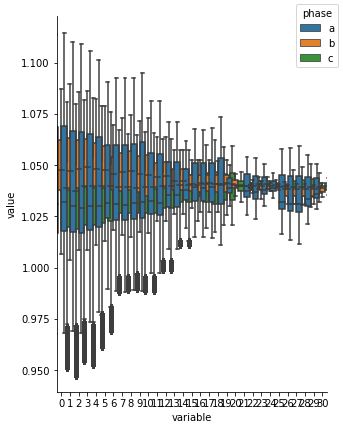

In [6]:
ax = sns.catplot(
    data=bus_df.loc[idx_to_plot],
    x="variable",
    y="value",
    hue="phase",
    kind="box",
    height=6,
    width=2,
    aspect=0.7,
    hue_order=["a", "b", "c"],
)
plt.tight_layout()
sns.move_legend(ax, "upper right")
